In [ ]:
import numpy as np
import torch
from torchvision import transforms, datasets


class VAE(torch.nn.Module):
    def __init__(
        self,
        input_dim: int = 784,
        num_layers: int = 2,
        hidden_layer: int = 400,
        zdim: int = 20,
    ) -> None:
        super(VAE, self).__init__()
        divisor = [2**power for power in range(0, num_layers)]
        hidden_layers = [int(hidden_layer / div) for div in divisor]
        assert (
            zdim < hidden_layers[-1]
        ), "bottle neck layer is bigger than last hidden layer"

        self.encoder_layers = torch.nn.ModuleList()
        start_dim = input_dim

        for h_layer in hidden_layers:
            self.encoder_layers.append(torch.nn.Linear(start_dim, h_layer))
            start_dim = h_layer
        self.mean = torch.nn.Linear(start_dim, zdim)
        self.logvar = torch.nn.Linear(start_dim, zdim)

        self.decoder_layers = torch.nn.ModuleList()
        start_dim = zdim
        for h_layer in hidden_layers[::-1]:
            self.decoder_layers.append(torch.nn.Linear(start_dim, h_layer))
            start_dim = h_layer
        self.decoder_layers.append(torch.nn.Linear(start_dim, input_dim))
        # import pdb; pdb.set_trace()
        self.initilialize_weights_biases()

    def initilialize_weights_biases(self) -> None:
        for layer in self.encoder_layers + self.decoder_layers:
            torch.nn.init.xavier_uniform_(layer.weight)
            torch.nn.init.zeros_(layer.bias)

    def encode(self, x: torch.Tensor) -> tuple:
        for layer in self.encoder_layers:
            x = torch.relu(layer(x))
        mean = self.mean(x)
        logvar = self.logvar(x)
        return (mean, logvar)

    def decode(self, z: torch.Tensor) -> torch.Tensor:
        for layer in self.decoder_layers[:-1]:
            z = torch.relu(layer(z))
        z = torch.sigmoid(self.decoder_layers[-1](z))
        return z

    def forward(self, x: torch.Tensor) -> tuple:
        x = x.view(-1, 784)
        (u, logvar) = self.encode(x)
        stdev = torch.exp(0.5 * logvar)
        noise = torch.randn_like(stdev)
        z = u + (noise * stdev)
        z = self.decode(z)
        return (z, u, logvar)


def cus_loss_func(
    recon_x: torch.Tensor, x: torch.Tensor, u: torch.Tensor, logvar: torch.Tensor
) -> torch.Tensor:
    # https://arxiv.org/abs/1312.6114
    # KLD = 0.5 * sum(1 + log(sigma^2) - u^2 - sigma^2)
    bce = torch.nn.functional.binary_cross_entropy(
        recon_x, x.view(-1, 784), reduction="sum"
    )
    kld = -0.5 * torch.sum(1 + logvar - u.pow(2) - logvar.exp())
    return bce + kld


device = torch.device("cuda")
torch.manual_seed(1)
np.random.seed(1)

# 1. load data
batch_size = 128
trfm = transforms.transforms.ToTensor()
train_ds = datasets.MNIST(".\\Data", train=True, download=True, transform=trfm)
train_ldr = torch.utils.data.DataLoader(train_ds, batch_size=batch_size, shuffle=True)

# 2. create model
vae = VAE(num_layers=3, hidden_layer=512, zdim=20).to(device)

# 3. train model
max_epochs = 20
lrn_rate = 0.001
optimizer = torch.optim.Adam(vae.parameters(), lr=lrn_rate)

print("\nbatch_size = %3d " % batch_size)
print("loss = custom BCE plus KLD ")
print("optimizer = Adam")
print("max_epochs = %3d " % max_epochs)
print("lrn_rate = %0.3f " % lrn_rate)

for epoch in range(0, max_epochs):
    vae = vae.train()
    torch.manual_seed(1 + epoch)
    train_loss = 0.0
    num_lines_read = 0
    for batch_idx, (data, _) in enumerate(train_ldr):
        num_lines_read += bat_size
        data = data.to(device)  # (bat_sz, 1, 28, 28)
        optimizer.zero_grad()
        recon_x, u, logvar = vae(data)
        loss_val = cus_loss_func(recon_x, data, u, logvar)
        loss_val.backward()
        train_loss += loss_val.item()
        optimizer.step()
    print(f"Epoch {epoch+1}/{max_epochs}, Loss: {train_loss/len(train_ds)}")


batch_size = 128 
loss = custom BCE plus KLD 
optimizer = Adam
max_epochs =  20 
lrn_rate = 0.001 
Epoch 1/20, Loss: 182.25809884440105
Epoch 2/20, Loss: 134.8313725423177
Epoch 3/20, Loss: 123.55537405598959
Epoch 4/20, Loss: 118.66257932942709
Epoch 5/20, Loss: 115.10262864583333
Epoch 6/20, Loss: 112.74797185872396
Epoch 7/20, Loss: 111.14719446614583
Epoch 8/20, Loss: 109.79577045898438
Epoch 9/20, Loss: 108.77934083658855
Epoch 10/20, Loss: 107.91430838216147
Epoch 11/20, Loss: 107.1952147298177
Epoch 12/20, Loss: 106.57149762369792
Epoch 13/20, Loss: 106.006639453125
Epoch 14/20, Loss: 105.4964057779948
Epoch 15/20, Loss: 105.01784931640626
Epoch 16/20, Loss: 104.63649498697917
Epoch 17/20, Loss: 104.28340065104166
Epoch 18/20, Loss: 103.94733133138021
Epoch 19/20, Loss: 103.6476060546875
Epoch 20/20, Loss: 103.3582823404948


In [ ]:
import matplotlib.pyplot as plt


def show_images(images, num_images=6, pred: bool = False):
    # Convert from PyTorch tensor to NumPy array
    images = images.view(-1, 28, 28).cpu().numpy() if not pred else images
    fig, axes = plt.subplots(1, num_images, figsize=(15, 15))
    for i in range(num_images):
        ax = axes[i]
        ax.imshow(images[i], cmap="gray")
        ax.axis("off")
    plt.show()

In [ ]:
data = next(iter(train_ldr))

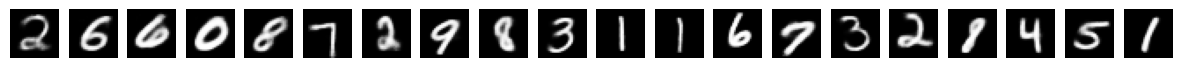

In [ ]:
vae.eval().to('cuda')
with torch.no_grad():
    recon_x, _, _ = vae(data[0].to('cuda'))
    show_images(recon_x, 20)

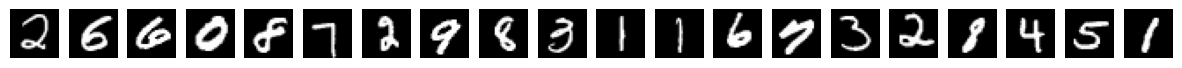

In [ ]:
show_images(data[0], 20)

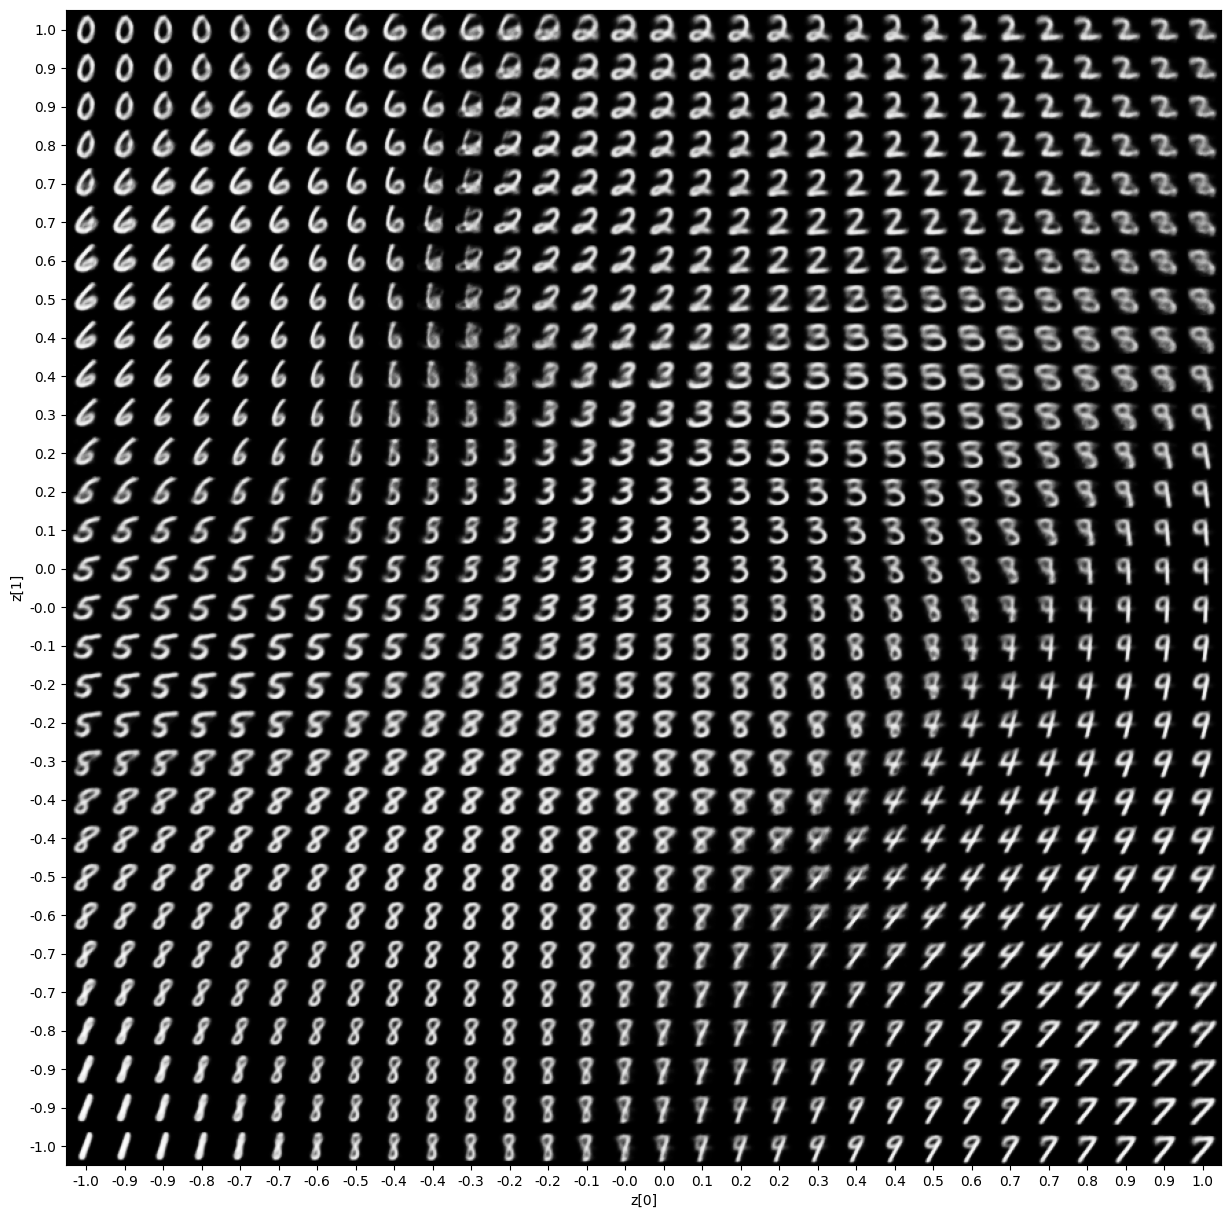

In [ ]:
import matplotlib.pyplot as plt


def plot_latent_space(vae, n=30, figsize=15):
    # display a n*n 2D manifold of digits
    digit_size = 28
    scale = 1.0
    figure = np.zeros((digit_size * n, digit_size * n))
    # linearly spaced coordinates corresponding to the 2D plot
    # of digit classes in the latent space
    grid_x = np.linspace(-scale, scale, n)
    grid_y = np.linspace(-scale, scale, n)[::-1]

    for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):
            z_sample = np.array([[xi, yi]])
            x_decoded = vae.decode(torch.tensor(z_sample, dtype=torch.float).to('cuda'))
            digit = x_decoded[0].reshape(digit_size, digit_size)
            figure[
                i * digit_size : (i + 1) * digit_size,
                j * digit_size : (j + 1) * digit_size,
            ] = digit.detach().cpu()

    plt.figure(figsize=(figsize, figsize))
    start_range = digit_size // 2
    end_range = n * digit_size + start_range
    pixel_range = np.arange(start_range, end_range, digit_size)
    sample_range_x = np.round(grid_x, 1)
    sample_range_y = np.round(grid_y, 1)
    plt.xticks(pixel_range, sample_range_x)
    plt.yticks(pixel_range, sample_range_y)
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.imshow(figure, cmap="Greys_r")
    plt.show()


plot_latent_space(vae)

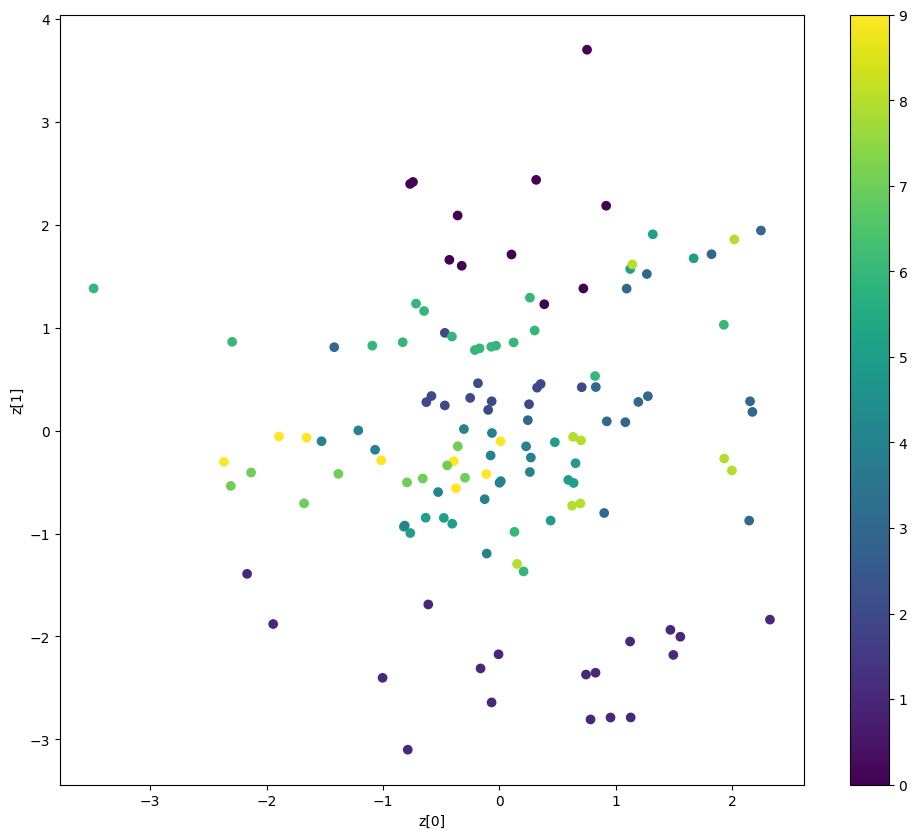

In [ ]:
def plot_label_clusters(vae, data, labels):
    # display a 2D plot of the digit classes in the latent space
    z_mean, _ = vae.encode(data.view(128, 784).to(device))
    z_mean = z_mean.cpu().detach().numpy()
    plt.figure(figsize=(12, 10))
    plt.scatter(z_mean[:, 0], z_mean[:, 1], c=labels)
    plt.colorbar()
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.show()

plot_label_clusters(vae, data[0], data[1].detach().numpy())